In [67]:
# Installer les bibliothèques nécessaires (exécuter dans Google Colab si nécessaire)
! pip install opencv-python
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn


In [68]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

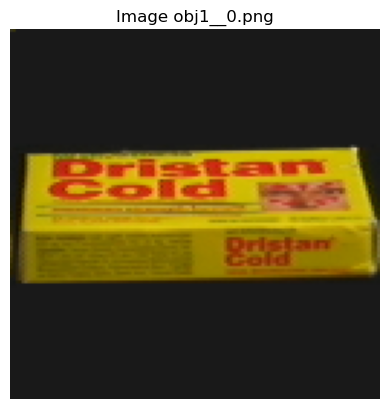

In [69]:
def read_image(image_path):
    # Lire une image depuis le chemin spécifié
    image = cv2.imread(image_path)
    return image

def show_image(image, title="Image"):
    # Convertir l'image de BGR (format OpenCV) à RGB (format Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Afficher l'image en utilisant Matplotlib
    plt.imshow(image_rgb)
    plt.title(title)  # Ajouter un titre à l'image
    plt.axis('off')  # Ne pas afficher les axes
    plt.show()

# Exemple d'utilisation
image_path = '/home/pepuere/Téléchargements/coil-100/obj1__0.png'
image = read_image(image_path)
show_image(image, title="Image obj1__0.png")

Étape 1 : Définir les fonctions pour calculer les caractéristiques
Nous avons déjà les fonctions pour calculer l'histogramme de couleur et les moments de Hu :

In [70]:
def calculate_color_histogram(image, bins=32):
    # Convertir l'image en espace de couleur HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calculer l'histogramme pour chaque canal (H, S, V)
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])
    # Normaliser les histogrammes et les aplatir en un vecteur
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()
    # Combiner les trois histogrammes en un seul vecteur
    hist = np.concatenate([hist_h, hist_s, hist_v])
    return hist

def calculate_hu_moments(image):
    # Convertir l'image en niveaux de gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculer les moments de l'image
    moments = cv2.moments(gray_image)
    # Calculer les moments de Hu à partir des moments
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments


Fonctions de distance

In [71]:
def chi2_distance(histA, histB, eps=1e-10):
    # Calculer la distance Chi-2 entre deux histogrammes
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    return d

def euclidean_distance(vecA, vecB):
    # Calculer la distance euclidienne entre deux vecteurs
    return np.sqrt(np.sum((vecA - vecB) ** 2))

Étape 2 : Extraire et stocker les caractéristiques des images de la base de donnee

In [72]:
def extract_features(dataset_path):
    features = []  # Liste pour stocker les caractéristiques des images

    # Parcourir chaque fichier dans le répertoire de la base de données
    for filename in os.listdir(dataset_path):
        if filename.endswith(".png"):  # Filtrer les fichiers avec l'extension .png
            image_path = os.path.join(dataset_path, filename)  # Chemin complet de l'image
            image = read_image(image_path)  # Lire l'image
            color_hist = calculate_color_histogram(image)  # Calculer l'histogramme de couleur
            hu_moments = calculate_hu_moments(image)  # Calculer les moments de Hu
            # Stocker les caractéristiques dans un dictionnaire
            features.append({
                'filename': filename,
                'color_hist': color_hist,
                'hu_moments': hu_moments
            })
    
    return features  # Retourner la liste des caractéristiques

# Exemple d'utilisation
dataset_path = '/home/pepuere/Téléchargements/coil-100'
image_features = extract_features(dataset_path)  # Extraire les caractéristiques des images

# Affichage des caractéristiques pour vérifier
for feature in image_features[:5]:  # Afficher les 5 premiers pour vérifier
    print(f"Filename: {feature['filename']}")
    print(f"Color Histogram: {feature['color_hist'][:5]}...")  # Afficher un extrait de l'histogramme
    print(f"Hu Moments: {feature['hu_moments']}")
    print("\n")

Filename: obj46__115.png
Color Histogram: [0.96312875 0.12860635 0.11816347 0.06333834 0.0035188 ]...
Hu Moments: [ 1.55932342e-03  8.08985754e-08  1.52107369e-11  2.98105022e-11
 -6.09194956e-22 -1.45194421e-15 -1.78431991e-22]


Filename: obj83__175.png
Color Histogram: [0.35431775 0.01044448 0.44037125 0.82114077 0.02508947]...
Hu Moments: [ 1.40765081e-03  2.09841948e-08  6.53008346e-11  3.61077016e-11
  1.44304259e-21 -4.39655716e-15 -9.95856440e-22]


Filename: obj19__185.png
Color Histogram: [0.9965043  0.02795191 0.01095715 0.01796376 0.00104354]...
Hu Moments: [ 2.92805053e-03  3.22896931e-07  2.09409922e-11  8.97491211e-11
  3.17961052e-21 -5.03330836e-14  2.24248792e-21]


Filename: obj82__155.png
Color Histogram: [0.08737507 0.00658382 0.00435201 0.06271365 0.17709354]...
Hu Moments: [ 2.66893180e-03  8.05276240e-09  1.76840980e-10  7.56966234e-10
 -1.07401603e-19  1.33378655e-15 -2.55280063e-19]


Filename: obj9__105.png
Color Histogram: [0.84792817 0.4963708  0.13671033 0

Étape 3 : Extraire les caractéristiques de l'image cible

In [73]:
def extract_target_features(image_path):
    image = read_image(image_path)  # Lire l'image cible
    color_hist = calculate_color_histogram(image)  # Calculer l'histogramme de couleur
    hu_moments = calculate_hu_moments(image)  # Calculer les moments de Hu
    # Stocker les caractéristiques de l'image cible dans un dictionnaire
    target_features = {
        'filename': os.path.basename(image_path),
        'color_hist': color_hist,
        'hu_moments': hu_moments
    }
    return target_features  # Retourner les caractéristiques de l'image cible

# Exemple d'utilisation
target_image_path = '/home/pepuere/Téléchargements/coil-100/obj1__0.png'
target_features = extract_target_features(target_image_path)  # Extraire les caractéristiques de l'image cible

# Affichage des caractéristiques de l'image cible
print(f"Filename: {target_features['filename']}")
print(f"Color Histogram: {target_features['color_hist'][:5]}...")  # Afficher un extrait de l'histogramme
print(f"Hu Moments: {target_features['hu_moments']}")

Filename: obj1__0.png
Color Histogram: [0.93750113 0.07455473 0.11900252 0.31834957 0.00400832]...
Hu Moments: [ 2.04219883e-03  4.21116292e-07  6.20846022e-13  5.48598071e-12
  5.10759253e-24  1.13608499e-15 -8.74173297e-24]


Trouvons les images similaires

In [74]:
def find_similar_images(target_features, image_features, N=5):
    distances = []  # Liste pour stocker les distances

    # Calculer la distance entre l'image cible et chaque image de la base de données
    for features in image_features:
        distance_color = chi2_distance(target_features['color_hist'], features['color_hist'])
        distance_shape = euclidean_distance(target_features['hu_moments'], features['hu_moments'])
        distance_total = 0.5 * distance_color + 0.5 * distance_shape  # Combiner les distances
        
        # Stocker la distance et le nom du fichier
        distances.append({
            'filename': features['filename'],
            'distance': distance_total
        })
    
    # Trier les distances par ordre croissant
    distances.sort(key=lambda x: x['distance'])
    
    return distances[:N]  # Retourner les N images les plus similaires

# Exemple d'utilisation
similar_images = find_similar_images(target_features, image_features, N=5)

# Affichage des résultats
for result in similar_images:
    print(f"Image: {result['filename']}, Distance: {result['distance']}")


Image: obj1__0.png, Distance: 0.0
Image: obj1__5.png, Distance: 0.006916426428147053
Image: obj1__10.png, Distance: 0.014462054471357878
Image: obj1__180.png, Distance: 0.01655134949854221
Image: obj1__355.png, Distance: 0.01696159880606793


Precision: 0.2
Recall: 1.0
F1 Score: 0.3333333333333333
Confusion Matrix:
[[7195    4]
 [   0    1]]


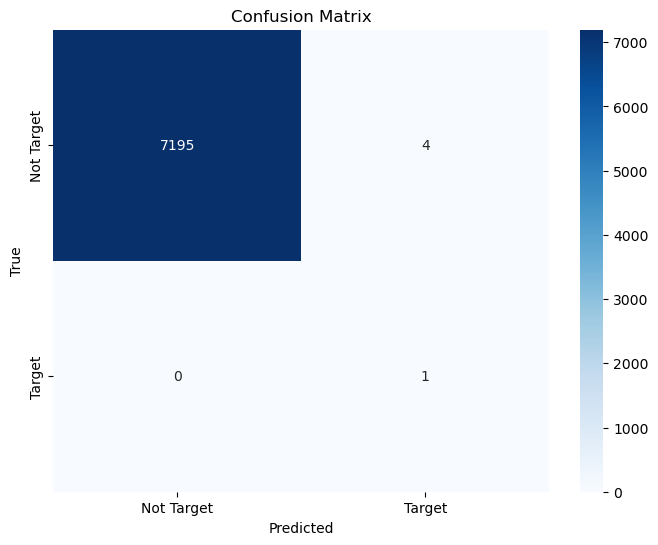

In [75]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_system(similar_images, ground_truth, all_images):
    # Créer les listes de prédictions et de vérité terrain
    y_true = []
    y_pred = []

    # Marquer les images similaires trouvées par le système
    for img in all_images:
        if img in ground_truth:
            y_true.append(1)  # 1 signifie que l'image fait partie de l'objet cible
        else:
            y_true.append(0)  # 0 signifie que l'image ne fait pas partie de l'objet cible
        
        if img in [res['filename'] for res in similar_images]:
            y_pred.append(1)  # 1 signifie que l'image a été prédite comme faisant partie de l'objet cible
        else:
            y_pred.append(0)  # 0 signifie que l'image n'a pas été prédite comme faisant partie de l'objet cible

    # Calculer les métriques
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return precision, recall, f1, cm

# Définir la vérité terrain et les images similaires
ground_truth = ['obj1__0.png', 'obj1__1.png', 'obj1__2.png', 'obj1__3.png', 'obj1__4.png']  # Exemple pour l'objet 1
all_images = [feature['filename'] for feature in image_features]  # Toutes les images de la base de données

# Évaluer le système
precision, recall, f1, cm = evaluate_system(similar_images, ground_truth, all_images)

# Afficher les résultats
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

# Afficher la matrice de confusion sous forme graphique
class_names = ['Not Target', 'Target']
plot_confusion_matrix(cm, class_names)


Methode de K-means

Étape 1 : Lire et afficher une image

Étape 1 : Extraction des caractéristiques des images

In [76]:
from sklearn.cluster import KMeans

def read_image(image_path):
    image = cv2.imread(image_path)
    return image

def calculate_color_histogram(image, bins=32):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()
    hist = np.concatenate([hist_h, hist_s, hist_v])
    return hist

def calculate_hu_moments(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_image)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

def extract_features(dataset_path):
    features = []
    filenames = []
    for filename in os.listdir(dataset_path):
        if filename.endswith(".png"):
            image_path = os.path.join(dataset_path, filename)
            image = read_image(image_path)
            color_hist = calculate_color_histogram(image)
            hu_moments = calculate_hu_moments(image)
            feature_vector = np.concatenate([color_hist, hu_moments])
            features.append(feature_vector)
            filenames.append(filename)
    return features, filenames

# Exemple d'utilisation
dataset_path = '/home/pepuere/Téléchargements/coil-100'
image_features, filenames = extract_features(dataset_path)


Étape 2 : Appliquer K-means sur les caractéristiques

In [77]:
from sklearn.cluster import KMeans

def apply_kmeans(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans

# Appliquer K-means sur les caractéristiques des images
n_clusters = 5
kmeans = apply_kmeans(image_features, n_clusters)
labels = kmeans.labels_

# Afficher les clusters
for i in range(n_clusters):
    print(f"Cluster {i}:")
    for idx, label in enumerate(labels):
        if label == i:
            print(f" - {filenames[idx]}")


Cluster 0:
 - obj46__115.png
 - obj19__185.png
 - obj9__105.png
 - obj90__75.png
 - obj92__305.png
 - obj33__105.png
 - obj38__350.png
 - obj22__210.png
 - obj69__60.png
 - obj62__355.png
 - obj88__260.png
 - obj90__90.png
 - obj93__320.png
 - obj46__285.png
 - obj92__120.png
 - obj73__30.png
 - obj87__15.png
 - obj23__355.png
 - obj13__340.png
 - obj21__330.png
 - obj15__70.png
 - obj33__190.png
 - obj76__150.png
 - obj87__300.png
 - obj62__40.png
 - obj19__25.png
 - obj50__30.png
 - obj4__35.png
 - obj53__195.png
 - obj93__170.png
 - obj94__65.png
 - obj6__325.png
 - obj97__75.png
 - obj5__145.png
 - obj37__215.png
 - obj49__210.png
 - obj52__70.png
 - obj7__140.png
 - obj94__265.png
 - obj19__210.png
 - obj6__220.png
 - obj33__115.png
 - obj23__105.png
 - obj61__175.png
 - obj22__20.png
 - obj92__310.png
 - obj33__325.png
 - obj39__100.png
 - obj49__80.png
 - obj93__290.png
 - obj36__20.png
 - obj1__200.png
 - obj47__160.png
 - obj8__145.png
 - obj72__215.png
 - obj33__45.png
 - obj

Étape 3 : Trouver les images similaires en utilisant les clusters K-means

In [78]:
def extract_target_features(image_path):
    image = read_image(image_path)
    color_hist = calculate_color_histogram(image)
    hu_moments = calculate_hu_moments(image)
    target_features = np.concatenate([color_hist, hu_moments])
    return target_features

def find_similar_images_kmeans(target_features, kmeans, image_features, filenames, N=10):
    cluster_label = kmeans.predict([target_features])[0]
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == cluster_label]
    
    distances = []
    for idx in cluster_indices:
        dist = np.linalg.norm(target_features - image_features[idx])
        distances.append((filenames[idx], dist))
    
    distances.sort(key=lambda x: x[1])
    return distances[:N]

# Exemple d'utilisation
target_image_path = '/home/pepuere/Téléchargements/coil-100/obj1__0.png'
target_features = extract_target_features(target_image_path)
similar_images_kmeans = find_similar_images_kmeans(target_features, kmeans, image_features, filenames, N=10)

# Affichage des résultats
for result in similar_images_kmeans:
    print(f"Image: {result[0]}, Distance: {result[1]}")


Image: obj1__0.png, Distance: 0.0
Image: obj1__5.png, Distance: 0.028603772740788645
Image: obj1__355.png, Distance: 0.03798570699803824
Image: obj1__10.png, Distance: 0.04159579347526135
Image: obj1__175.png, Distance: 0.06130469312803649
Image: obj1__180.png, Distance: 0.06496240154116113
Image: obj1__15.png, Distance: 0.0672555416384935
Image: obj1__350.png, Distance: 0.06873785766758281
Image: obj1__170.png, Distance: 0.07077907732413846
Image: obj1__190.png, Distance: 0.07178206848600226


Étape 4 : Évaluation et Affichage de la Matrice de Confusion

Precision: 0.4
Recall: 0.26666666666666666
F1 Score: 0.32
Confusion Matrix:
[[7179    6]
 [  11    4]]


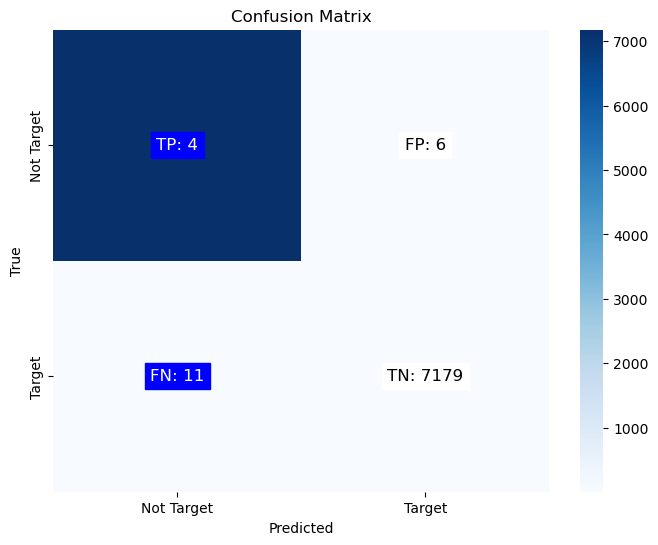

In [79]:
def evaluate_system_kmeans(similar_images, ground_truth, all_images):
    y_true = []
    y_pred = []

    for img in all_images:
        if img in ground_truth:
            y_true.append(1)  # 1 signifie que l'image fait partie de l'objet cible
        else:
            y_true.append(0)  # 0 signifie que l'image ne fait pas partie de l'objet cible
        
        if img in [si[0] for si in similar_images]:
            y_pred.append(1)  # 1 signifie que l'image a été prédite comme faisant partie de l'objet cible
        else:
            y_pred.append(0)  # 0 signifie que l'image n'a pas été prédite comme faisant partie de l'objet cible

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return precision, recall, f1, cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
    # Annoter les cases avec les valeurs TP, FP, FN, TN
    plt.text(0.5, 0.5, f'TP: {cm[1, 1]}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='white', backgroundcolor='blue')
    plt.text(0.5, 1.5, f'FN: {cm[1, 0]}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='white', backgroundcolor='blue')
    plt.text(1.5, 0.5, f'FP: {cm[0, 1]}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', backgroundcolor='white')
    plt.text(1.5, 1.5, f'TN: {cm[0, 0]}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', backgroundcolor='white')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Définir la vérité terrain pour l'objet cible
ground_truth = [f'obj1__{i}.png' for i in range(72)]  # Liste des images faisant partie de l'objet cible
all_images = filenames  # Liste de toutes les images

# Évaluer le système
precision, recall, f1, cm = evaluate_system_kmeans(similar_images_kmeans, ground_truth, all_images)

# Afficher les résultats
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

# Afficher la matrice de confusion sous forme graphique
class_names = ['Not Target', 'Target']
plot_confusion_matrix(cm, class_names)
